# Détection de faux billets

## Sommaire : 
    - mise en context
    - preprocessing
    - analyse univarié / bivarié / multivarié
    - acp
    - classification / clustering
    - regression logistique  
    - programme de détéction de faux billets
    

## mise en context :
    Nous avons était engagé pour une mission auprès du minitère de l'intérieur
    dans le cadre de la luttre contre la criminalité organisée, à l'office central pour la répression du faux
    monnayage.
    Notre mission crée un algorithme de détection de faux billets.

## Preprocessing 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 

In [2]:
from sklearn import decomposition 
from sklearn import preprocessing
from sklearn.cluster import KMeans

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

In [3]:
from TableauImg import *
from utility import *
from functions import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
# reglage matplotlib
plt.style.use('ggplot')

# reglage de seaborn
sns.set(
    style='darkgrid',
    context='notebook',
    color_codes=True,
    palette='Paired',
    rc={'figure.figsize':(8,5)}
)

pd.options.display.float_format = '{:,.2f}'.format

In [5]:
url = 'graph/'

#### importation des données
##### exploration des données

In [6]:
df = pd.read_csv('notes.csv')

In [7]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


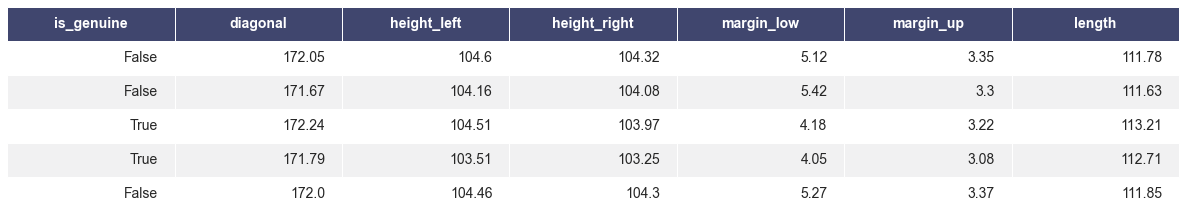

In [8]:
render_mpl_table(df.sample(5))
plt.savefig(url + 'dataset', dpi=300)

In [9]:
df.shape

(170, 7)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [11]:
df.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,170,170.00,170.00,170.00,170.00,170.00,170.00
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.94,104.07,103.93,4.61,3.17,112.57
std,NaN,0.31,0.30,0.33,0.70,0.24,0.92
min,NaN,171.04,103.23,103.14,3.54,2.27,109.97
25%,NaN,171.73,103.84,103.69,4.05,3.01,111.85
50%,NaN,171.94,104.06,103.95,4.45,3.17,112.84
75%,NaN,172.14,104.29,104.17,5.13,3.33,113.29


In [12]:
df['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

# analyse des données univariée / bivariée

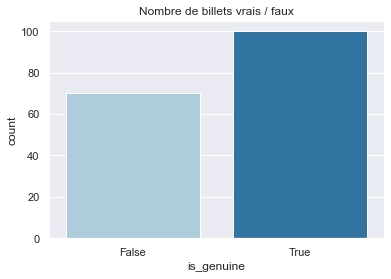

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_genuine')
plt.title('Nombre de billets vrais / faux')
plt.savefig(url + 'nombre_f_v_billets', dpi=300)
plt.show()

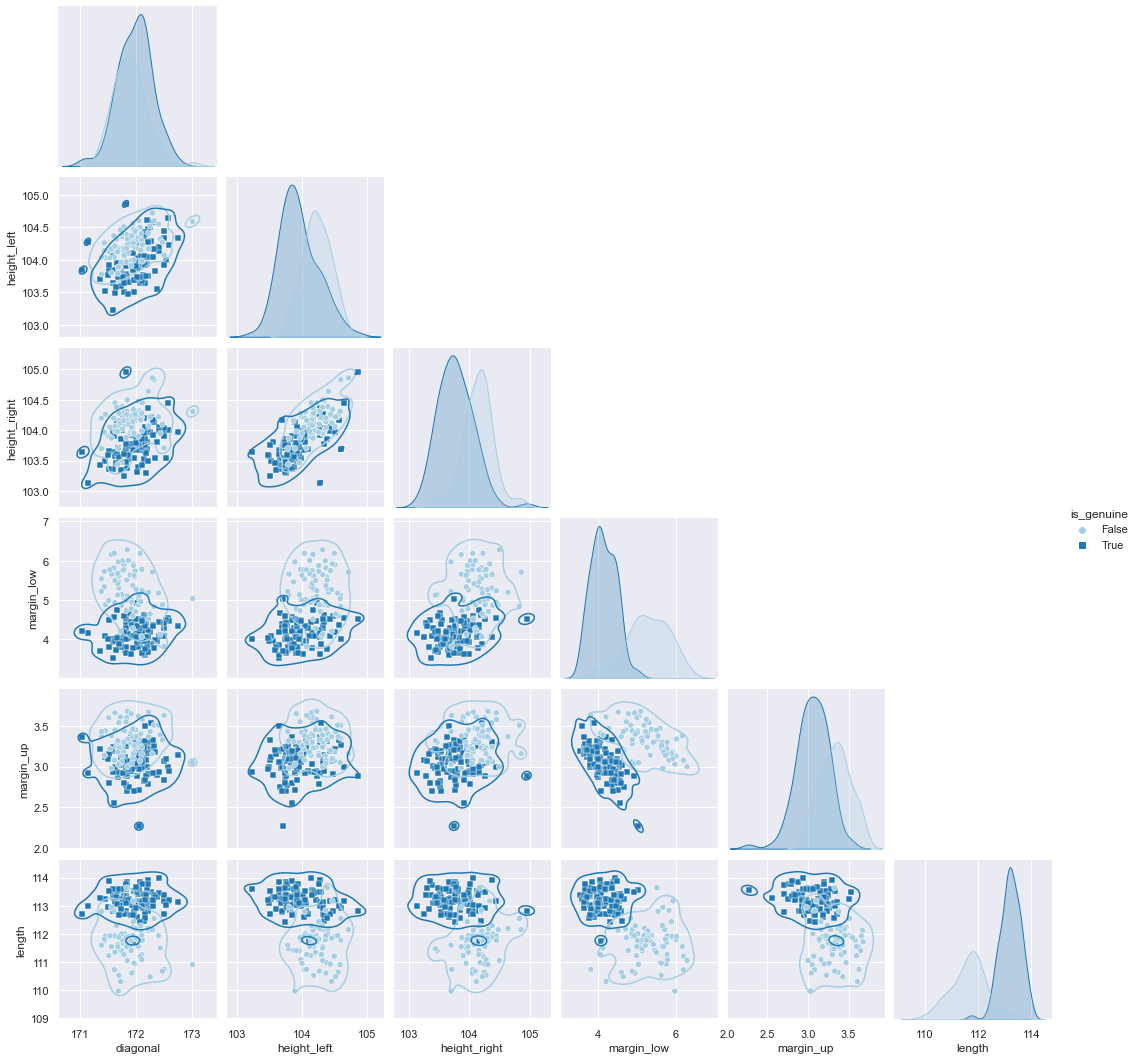

In [14]:
pair_p = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
pair_p.map_lower(sns.kdeplot, levels=2, color='.2')
plt.savefig(url+'distribution_par_authentitite', dpi=300)
plt.show()

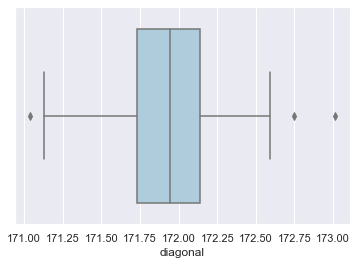

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='diagonal', hue='is_genuine')
plt.show()

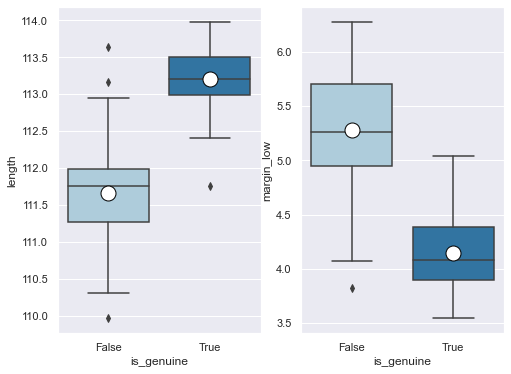

In [16]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}
sns.boxplot(data=df, y='length', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[0])
sns.boxplot(data=df, y='margin_low', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[1])
plt.savefig(url + 'boxplots', dpi=300)
plt.show()

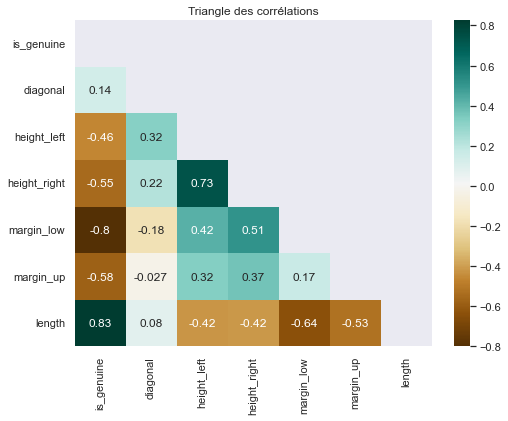

In [17]:
matrix = df.corr()

mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
plt.savefig(url + 'triangle_correlations', dpi=300)
plt.show()

## ACP

In [18]:
# standardisation des données
X = df.drop(['is_genuine'], axis=1)
std = preprocessing.StandardScaler().fit(X)
X_std = pd.DataFrame(std.transform(X), columns=X.columns)

In [19]:
X_std

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.43,2.67,3.10,-0.13,-1.19,0.28
1,-0.89,-1.10,-0.69,-0.86,-1.27,0.78
2,-0.36,-1.03,-0.51,-0.30,-1.23,1.38
3,-0.46,-0.96,-0.84,-1.26,-0.21,1.15
4,0.36,-1.23,-0.54,0.61,-3.82,1.06
...,...,...,...,...,...,...
165,0.56,0.55,1.58,0.90,1.74,-0.86
166,3.51,1.76,1.16,0.61,-0.51,-1.80
167,1.74,0.68,0.52,0.38,0.68,-2.05
168,-0.40,-0.32,-0.15,0.17,1.61,-0.76


In [20]:
X_std.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.00,170.00,170.00,170.00,170.00,170.00
mean,0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.95,-2.81,-2.39,-1.53,-3.82,-2.82
25%,-0.69,-0.75,-0.72,-0.80,-0.67,-0.78
50%,0.01,-0.04,0.07,-0.23,-0.00,0.30
75%,0.65,0.74,0.73,0.74,0.68,0.78
max,3.51,2.67,3.10,2.38,2.16,1.53


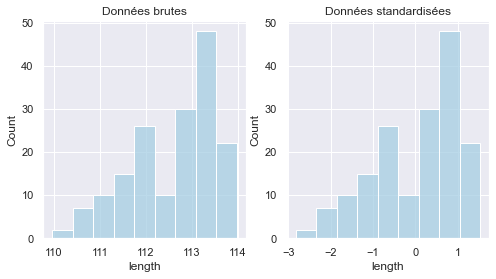

In [21]:
# comparaison données brute / données standardisées
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(df['length'], ax=ax[0])
sns.histplot(X_std['length'], ax=ax[1])
ax[0].title.set_text('Données brutes')
ax[1].title.set_text('Données standardisées')
plt.savefig(url + 'histogramme_std', dpi=300)
plt.show()

In [22]:
martix = X_std.cov()
matrix

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.00,0.14,-0.46,-0.55,-0.80,-0.58,0.83
diagonal,0.14,1.00,0.32,0.22,-0.18,-0.03,0.08
height_left,-0.46,0.32,1.00,0.73,0.42,0.32,-0.42
height_right,-0.55,0.22,0.73,1.00,0.51,0.37,-0.42
margin_low,-0.80,-0.18,0.42,0.51,1.00,0.17,-0.64
margin_up,-0.58,-0.03,0.32,0.37,0.17,1.00,-0.53
length,0.83,0.08,-0.42,-0.42,-0.64,-0.53,1.00


In [23]:
from sklearn.decomposition import PCA

In [24]:
n_comp = 2

pca = PCA(n_components= n_comp).fit(X_std)
print(
    'Variance expliquée :', 
    round(sum(pca.explained_variance_ratio_) * 100, 1), '%',
    '\nVariance par composante :', pca.explained_variance_ratio_)

Variance expliquée : 69.4 % 
Variance par composante : [0.47447921 0.21957106]


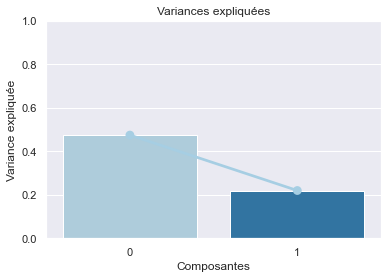

In [25]:
ind = np.arange(0, n_comp)
(fig, ax) = plt.subplots(figsize=(6, 4))
sns.barplot(x=ind, y=pca.explained_variance_ratio_)
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Variances expliquées')
ax.set_ylim(0,1)
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Composantes')
ax.set_ylabel('Variance expliquée')
plt.savefig(url+'variance_expliquee', dpi=300)
plt.show()

In [26]:
pca = PCA(n_components=n_comp)
reduced = pca.fit_transform(X_std)

for i in range(0, n_comp): 
    df['PC' + str(i + 1)] = reduced[:, i]
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.15,1.60
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.11,-0.53
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.97,-0.05
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.06,-0.09
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.40,0.41
...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,2.48,0.19
166,False,173.01,104.59,104.31,5.04,3.05,110.91,2.59,2.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68,2.07,0.85
168,False,171.82,103.97,103.88,4.73,3.55,111.87,0.74,-0.97


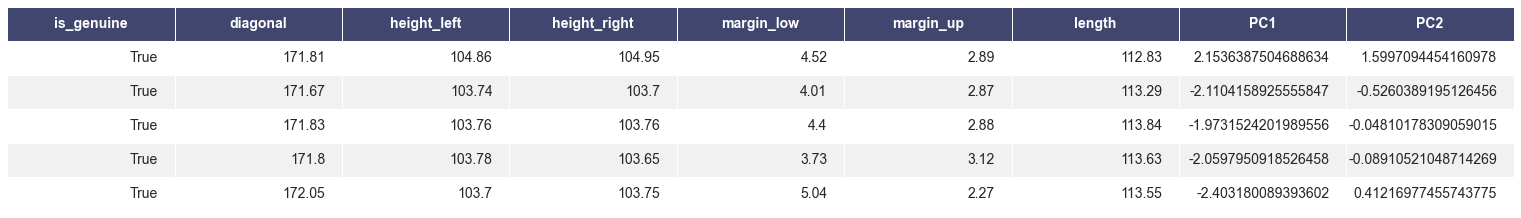

In [27]:
render_mpl_table(df.head(5))
plt.savefig(url + 'df_acp', dpi=300)

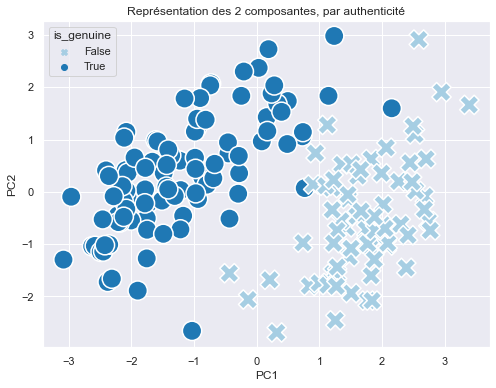

In [28]:
# representation en 2 dimensions des 2 composantes de l'acp 
plt.figure(figsize=(8, 6))
scatter_markers = ['X','o']
sns.scatterplot(data=df, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', markers=scatter_markers, s=375)
plt.title('Représentation des 2 composantes, par authenticité')
plt.savefig(url+'acp_2_comp', dpi=300)
plt.show()

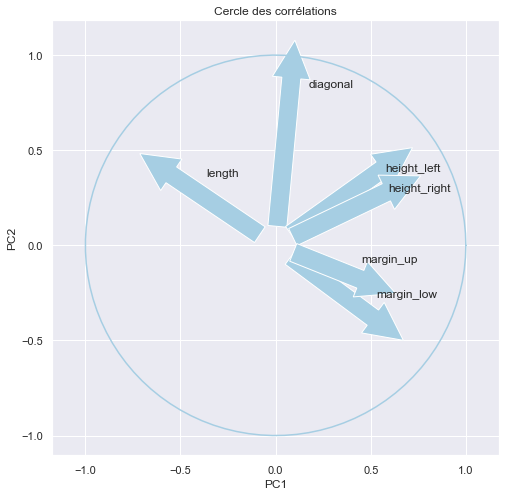

In [29]:
# cercle de corrélation

# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.2,
             head_length=0.2, width=.1, head_starts_at_zero=True)
    
    plt.text(pca.components_[0, i] + .1,
             pca.components_[1, i] + .05,
             X_std.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Cercle des corrélations')
plt.savefig(url+'cercle_correlation', dpi=300)
plt.show()

## KMEANS CLASSIFICATION

In [30]:
from sklearn import cluster

In [31]:
kmeans = sk.cluster.KMeans(n_clusters=2 , random_state=0).fit(X)
df['cluster'] = kmeans.predict(X)
dicto = {0: 1, 1: 0} # Inversion des 0 et des 1
df['cluster'] = df['cluster'].map(dicto) #0 soit égal à False
df


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.15,1.60,1
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.11,-0.53,1
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.97,-0.05,1
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.06,-0.09,1
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.40,0.41,1
...,...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,2.48,0.19,0
166,False,173.01,104.59,104.31,5.04,3.05,110.91,2.59,2.91,0
167,False,172.47,104.27,104.10,4.88,3.33,110.68,2.07,0.85,0
168,False,171.82,103.97,103.88,4.73,3.55,111.87,0.74,-0.97,0


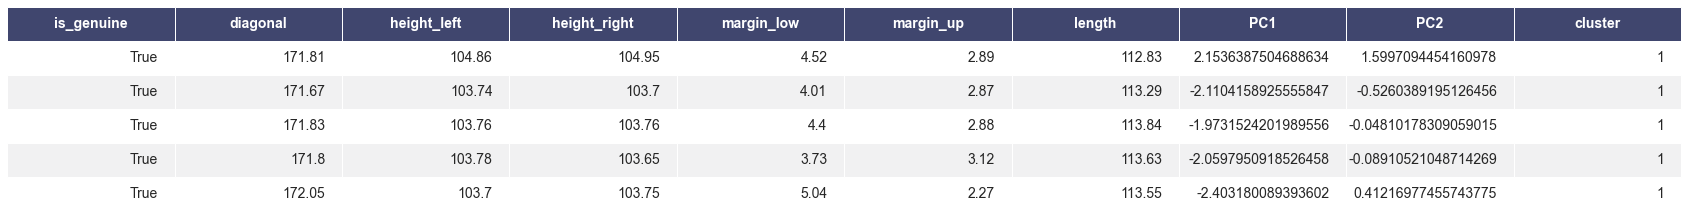

In [32]:
render_mpl_table(df.head(5))
plt.savefig(url + 'df_cluster', dpi=300)

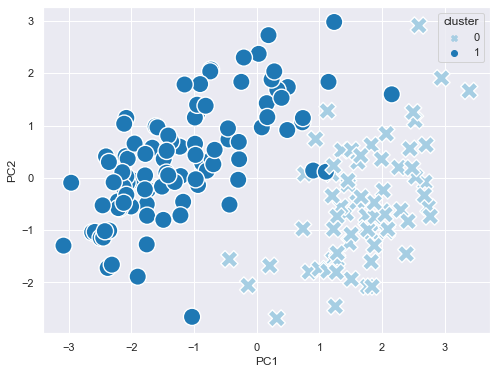

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', style='cluster', markers=scatter_markers, s=300)
plt.savefig(url+'nuage_cluser_1', dpi=300)
plt.show()

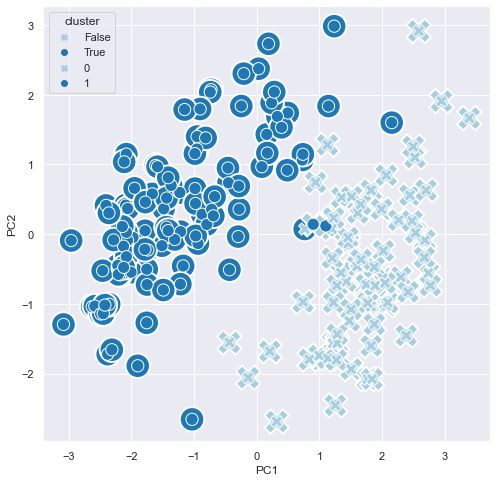

In [34]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='PC1', y='PC2', markers=scatter_markers, style='is_genuine', hue='is_genuine', s=600)
sns.scatterplot(data=df, x='PC1', y='PC2', markers=scatter_markers, style='cluster', hue='cluster', s=150)
plt.savefig(url+'nuage_cluster_2', dpi=300)
plt.show() # Contour = classe réelle ; Point = cluster

On vérifie le nombre d'individus vrais détectés faux 
avec une **matrice de confusion**.

|                      | Prédit : faux  | Prédit : vrai  |
| -------------------- |:-------------: | -------------: |
| Valeur réelle : faux | Vrais négatifs | Faux positifs  |
| Valeur réelle : vrai | Faux négatifs  | Vrais positifs |

Deux faux billets ont été considérés comme vrais par le clustering, et seul un vrai billet a été détecté comme faux.

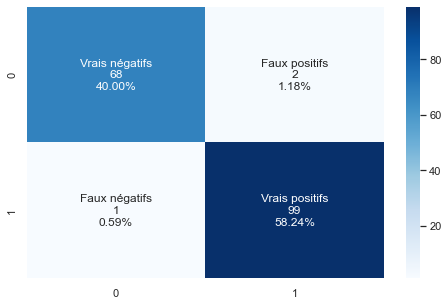

              precision    recall  f1-score   support

       False       0.99      0.97      0.98        70
        True       0.98      0.99      0.99       100

    accuracy                           0.98       170
   macro avg       0.98      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170



In [35]:
def matrice_confusion(a, b, nom_graphique):
    confusion_matrix = sk.metrics.confusion_matrix(a,b)
    group_names = ['Vrais négatifs','Faux positifs','Faux négatifs','Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = [
        '{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.savefig(url+nom_graphique, dpi=300)
    plt.show()
    
    classification = sk.metrics.classification_report(a,b)
    print(classification)
    
matrice_confusion(df['is_genuine'], df['cluster'], 'kmeans_matrice-confusion')

In [36]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


## LOGISTIC REGRESSION 

In [37]:
y = df['is_genuine']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X_std, y, test_size=0.33, random_state=42)

print('X_train :', len(X_train), 'lignes',
    '\ny_train :', len(y_train), 'lignes',
    '\nX_test :', len(X_test), 'lignes',
    '\ny_test :', len(y_test), 'lignes')


X_train : 113 lignes 
y_train : 113 lignes 
X_test : 57 lignes 
y_test : 57 lignes


In [38]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(random_state=0, strategy='uniform')
dummy.fit(X_train, y_train)
y_pred_dum = dummy.predict(X_test)
print(y_pred_dum)

[False  True  True False  True  True  True  True  True  True  True False
 False  True False False False False False  True False  True  True False
 False  True  True  True  True False  True False  True False  True  True
 False  True  True False False  True False  True  True  True  True  True
 False  True False  True  True  True  True False  True]


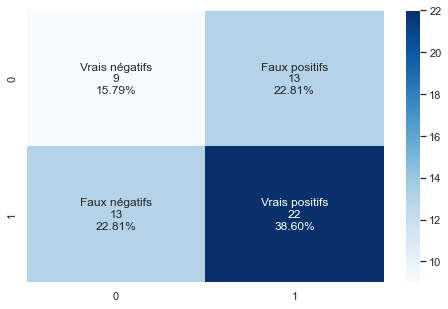

              precision    recall  f1-score   support

       False       0.41      0.41      0.41        22
        True       0.63      0.63      0.63        35

    accuracy                           0.54        57
   macro avg       0.52      0.52      0.52        57
weighted avg       0.54      0.54      0.54        57



In [39]:
matrice_confusion(y_test, y_pred_dum, 'dummy matrice')

In [40]:
regression = sk.linear_model.LogisticRegression()
regression.fit(X_train, y_train)


pd.DataFrame(
    regression.predict_proba(X_test)).rename(
    columns={0: 'False', 1: 'True'}).head(10)

,False,True
0,0.89,0.11
1,0.01,0.99
2,1.00,0.00
3,0.00,1.00
4,0.50,0.50
5,1.00,0.00
6,0.96,0.04
7,0.06,0.94
8,0.96,0.04
9,0.00,1.00


In [41]:
regression.intercept_


array([0.90023436])

In [42]:
regression.coef_

array([[ 0.13882195, -0.19305063, -0.50972116, -1.92453316, -1.43368165,
         1.82541401]])

In [43]:
log = regression.predict(X_test)

In [44]:
print(log)

[False  True False  True  True False False  True False  True  True False
 False  True  True  True  True False  True False  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
  True  True False False  True False  True False False  True  True  True
 False  True False False  True  True  True False  True]


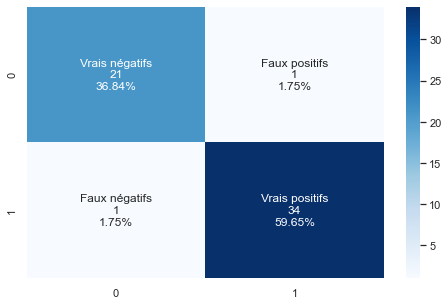

              precision    recall  f1-score   support

       False       0.95      0.95      0.95        22
        True       0.97      0.97      0.97        35

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



In [45]:
matrice_confusion(y_test, log, 'reg_matrice_conf')

# Shap

SHAP est un outil permettant d'expliquer la sortie d'un modèle. Les variables y sont classées par leur force de contribution au modèle. Comme attendu, la longueur et la marge basse arrivent en tête.

En abscisse, l'impact de chaque variable sur le modèle. Les valeurs rouges indiquent les plus grandes valeurs de la variable, les bleues ses plus faibles. Le modèle est surtout influencé par les marges basses les plus faibles (en bleu) et les plus grandes des longueurs.

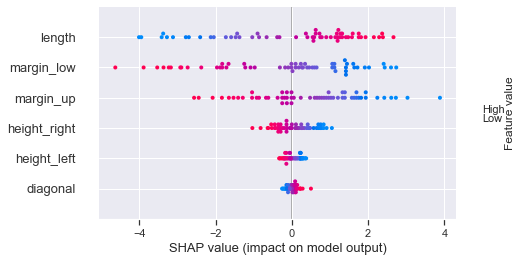

In [46]:
import shap 
explainer = shap.LinearExplainer(regression, X_train, feature_preturbation='interventional')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns.to_list())

In [47]:
# force_plot permet de pour chaque billet de vérifier quelles varibales ont impactés les 2 probabilités de classe. 

def force_plot(num_billet):
    print('Billet', num_billet, ':', y_test.iloc[num_billet])
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value, shap_values[num_billet], 
        X_test.iloc[num_billet].values, feature_names=X.columns.to_list())
    
force_plot(5)

Billet 5 : False


Ici, la marge basse et la longueur pointent en bleu et vers la gauche 
elles ont contribué à la classe False

In [48]:
force_plot(24)

Billet 24 : True


Quand les variables pointent en rouge vers la droite, elle contribuent à la classe True 

# PROGRAMMME DE DETECTION DES FAUX BILLETS

In [49]:
train_dict = {}
train_dict[0] = std
train_dict[1] = regression
train_dict[2] = pca

In [50]:
import pickle

In [51]:
pickle.dump(train_dict, open('train.p', 'wb'))

# Scripte de détéction de faux billets

In [52]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import pickle



def detection(example, nom_graph, nom_tableau):
    train_dict = pickle.load(open('train.p', 'rb'))
    std = train_dict[0]
    regression = train_dict[1]
    pca = train_dict[2]
   
    
    example = pd.read_csv(example) 
    X_csv = example.drop(['id'], axis=1)    
    X_csv = pd.DataFrame(std.transform(X_csv), columns=X_csv.columns) 
    
    
    y_log = regression.predict(X_csv) 
    predictions = []
    for i in range(0, len(y_log)):
        predictions.append(y_log[i])
    
    predictions = pd.concat([
        pd.DataFrame(
        [predictions]).rename(index={0: 'Prédiction'}).T.replace(
        {False: 'Faux billet', True: 'Vrai billet'}),
        pd.DataFrame(
        regression.predict_proba(X_csv)).rename(
        columns={0: 'Probabilité de faux', 1: 'Probabilité de vrai'})], axis=1)
    predictions['id'] = example['id'].unique() 
    
    n_components = 2
    reduced = pca.transform(X_csv)
    for i in range(0, n_components):
        predictions['PC' + str(i + 1)] = reduced[:, i]   
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=predictions, x='PC1', y='PC2', markers=['X','o'],
                    hue='Prédiction', style='Prédiction', s=2500, palette=['#ff5252', '#1de9b6'])
    plt.title('Projection des billets sur 2 dimensions')
    plt.savefig(url+nom_graph, dpi=300)
    plt.show()
    
    render_mpl_table(predictions.iloc[:,:-2])
    plt.savefig(url + nom_tableau, dpi=300)
    

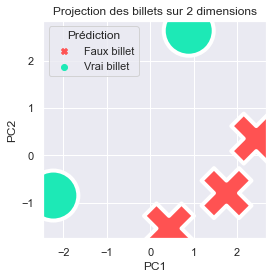

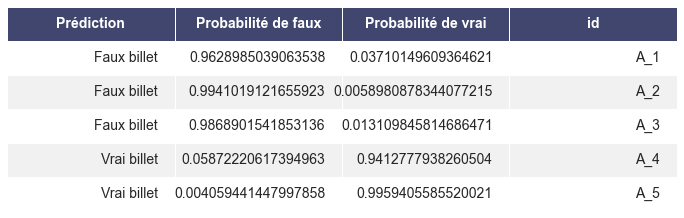

In [53]:
detection('example.csv', 'predictions', 'prediction_tab')